In [ ]:
%pip install scanpy
%pip install decoupler
%pip install leidenalg
%pip install omnipath

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc

In [2]:
# Data load
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
adata

AnnData object with n_obs × n_vars = 14404 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'A

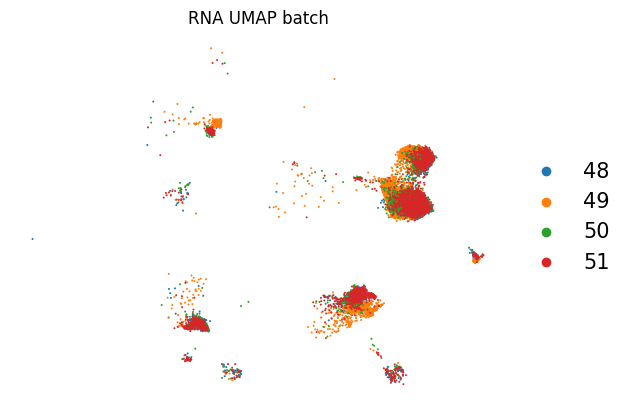

In [3]:
# Batch visualisation
sc.pl.umap(adata, color='batch', title='RNA UMAP batch', frameon=False, legend_fontweight='normal', legend_fontsize=15)

### Filtering and quality control

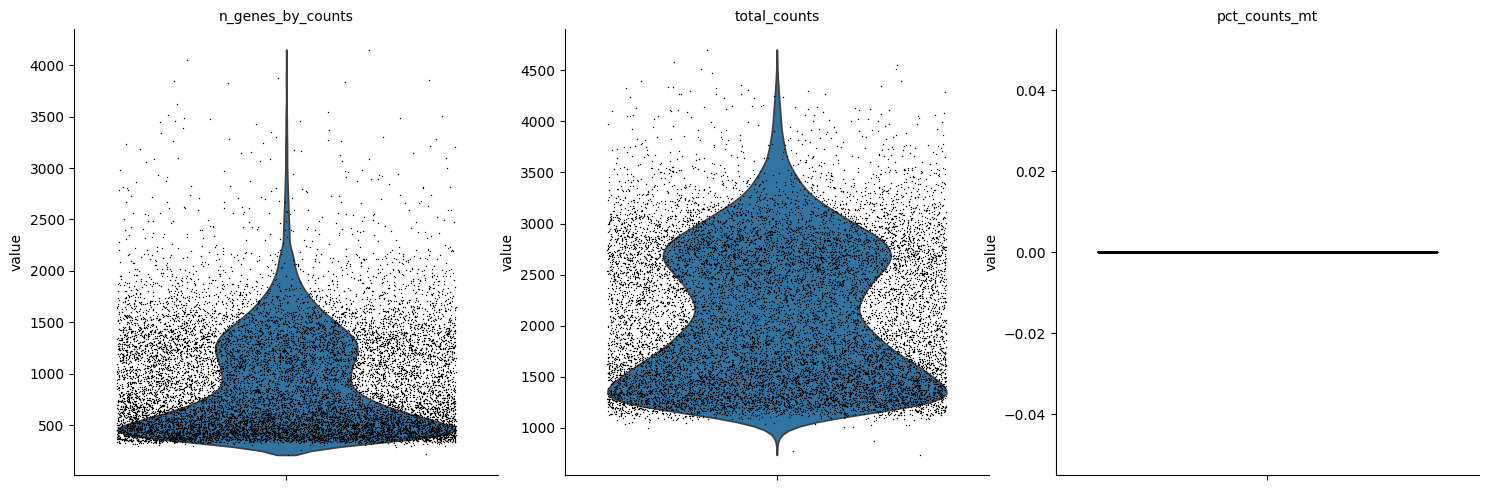

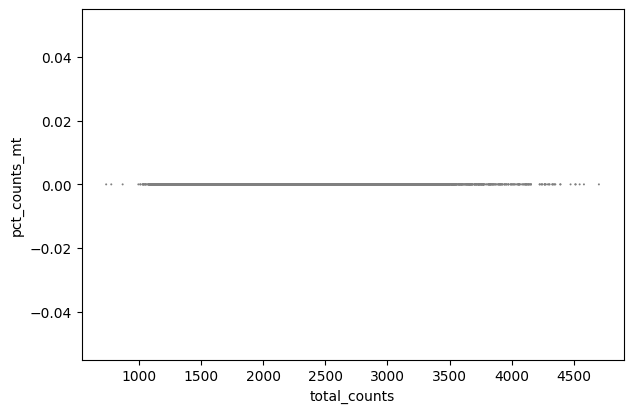

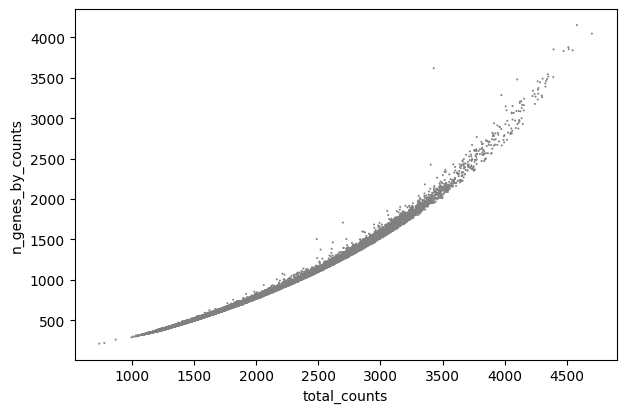

AnnData object with n_obs × n_vars = 14404 × 16803
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', '

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")
adata

In [7]:
# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
ada1 = adata.copy()

### Normalization, scaling, dimensionality reduction

In [8]:
# Normalize the data
sc.pp.normalize_total(ada1, target_sum=1e4)
sc.pp.log1p(ada1)
ada1.layers['log_norm'] = ada1.X.copy()

In [9]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(ada1, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(ada1, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(ada1, max_value=10)

# Generate PCA features
sc.tl.pca(ada1, svd_solver='arpack')

#Restore X to be norm counts
dc.swap_layer(ada1, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada1, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(ada1)

/Users/dejandraskovic/Desktop/Master/GI/Exercise3/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Clustering

/var/folders/xj/xhxrc13916n8vz62h202w3v00000gn/T/ipykernel_80221/225620511.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ada1)


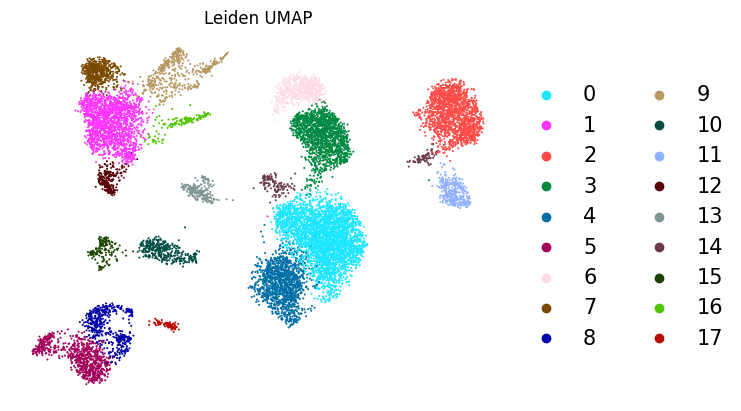

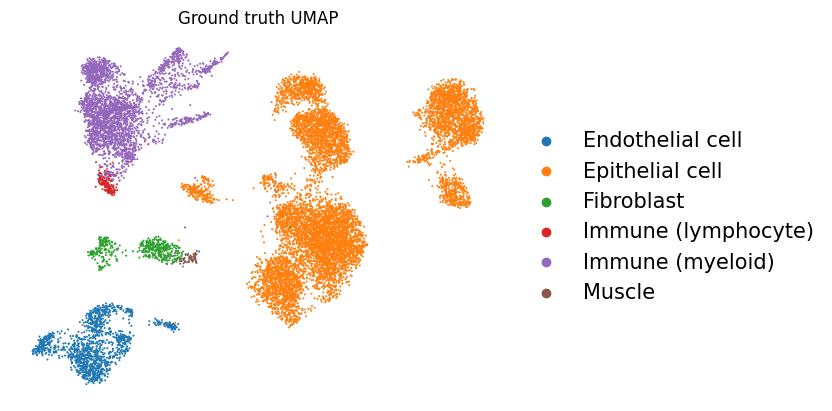

In [10]:
# Run leiden clustering algorithm
sc.tl.leiden(ada1)

# Visualize
sc.pl.umap(ada1, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada1, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

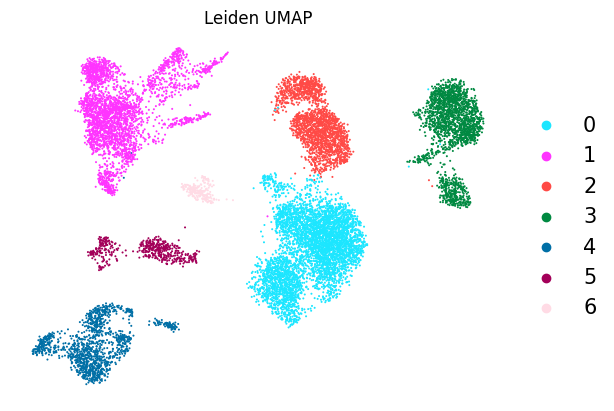

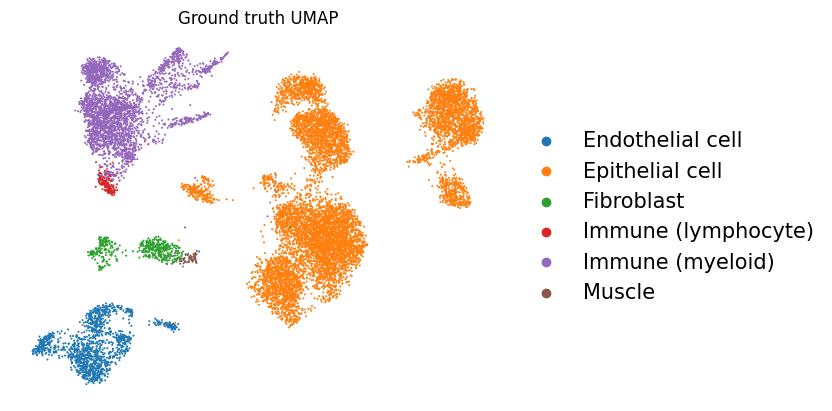

In [11]:
# Reapply it with lower resolution
sc.tl.leiden(ada1, resolution=0.1)

# Visualize
sc.pl.umap(ada1, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada1, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

### Davies Bouldin score

In [12]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(ada1.obsm['X_umap'], ada1.obs['leiden'].astype(int))
print(f"Davies-Bouldin score: {db_score}")

Davies-Bouldin score: 0.47788445089286025


### Re-evaluation without normalization

In [13]:
ada2 = adata.copy()

# Generate PCA features
sc.tl.pca(ada2, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada2, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(ada2)

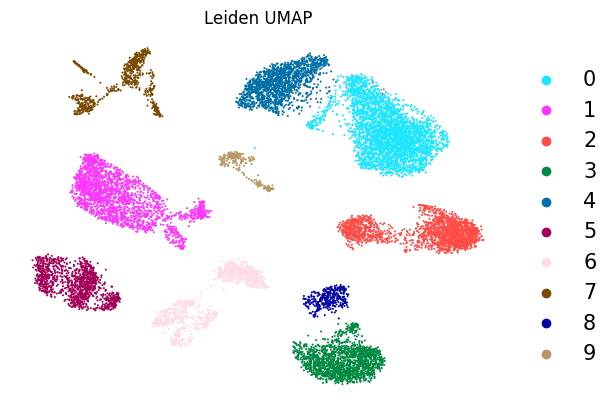

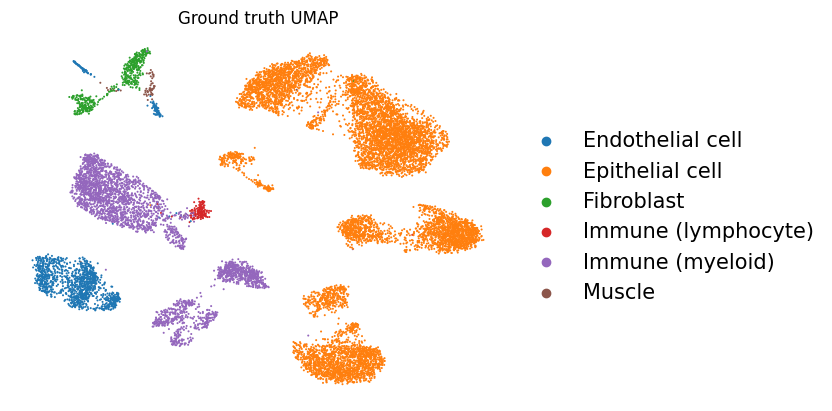

In [14]:
# Run leiden clustering algorithm
sc.tl.leiden(ada2, resolution=0.1)

# Visualize
sc.pl.umap(ada2, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada2, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [15]:
db_score = davies_bouldin_score(ada2.obsm['X_umap'], ada2.obs['leiden'].astype(int))
print(f"Davies-Bouldin score: {db_score}")

Davies-Bouldin score: 0.5083484157313867


Davies-Bouldin score with normalization: 0.47788445089286025

Davies-Bouldin score without normalization: 0.5083484157313867

Normalization didn't significantly affect the Davies-Bouldin score, as the difference is just over 0.02. 

Both scores indicate that the clusters were well-separated and compact, although the clustering wasn't entirely accurate when compared to the true clusters. 

Interestingly, the number of clusters increased when normalization was skipped, suggesting that despite the relatively good score, the clustering deviated further from the actual clusters.